# Method 9 - Best Ideas Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

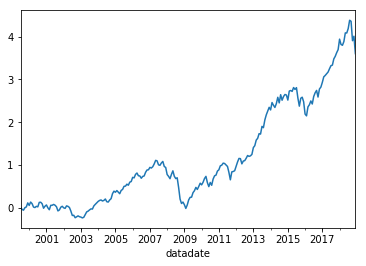

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.110124
2000-12-31   -0.069268
2001-12-31   -0.001573
2002-12-31   -0.236866
2003-12-31    0.409124
2004-12-31    0.249058
2005-12-31    0.162411
2006-12-31    0.170380
2007-12-31    0.029102
2008-12-31   -0.417366
2009-12-31    0.390716
2010-12-31    0.180204
2011-12-31    0.004611
2012-12-31    0.205347
2013-12-31    0.489999
2014-12-31    0.086177
2015-12-31   -0.043863
2016-12-31    0.099189
2017-12-31    0.229519
2018-12-31   -0.020202
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     618.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.86e-121
Time:                        20:27:01   Log-Likelihood:                 677.38
No. Observations:                 234   AIC:                            -1345.
Df Residuals:                     229   BIC:                            -1327.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.765      0.006       0.001       0.004
mktrf          0.9517      0.025     37.718      0.000       0.902       1.001
me             0.2825      0.029      9.624      0.000       0.225       0.340
ia            -0.0331      0.045     -0.741      0.459      -0.121       0.055
roe            0.0631      0.038      1.653      0.100      -0.012       0.138
==============================================================================
Omnibus:                       17.048   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.261
Skew:                          -0.229   Prob(JB):                     2.45e-10
Kurtosis:                       5.081   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     554.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.61e-116
Time:                        20:27:01   Log-Likelihood:                 677.38
No. Observations:                 234   AIC:                            -1345.
Df Residuals:                     229   BIC:                            -1327.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.518      0.012       0.001       0.005
mktrf          0.9517      0.027     34.965      0.000       0.898       1.005
me             0.2825      0.037      7.655      0.000       0.210       0.355
ia            -0.0331      0.075     -0.443      0.658      -0.179       0.113
roe            0.0631      0.047      1.354      0.176      -0.028       0.155
==============================================================================
Omnibus:                       17.048   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.261
Skew:                          -0.229   Prob(JB):                     2.45e-10
Kurtosis:                       5.081   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     729.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.29e-129
Time:                        20:27:01   Log-Likelihood:                 677.38
No. Observations:                 234   AIC:                            -1345.
Df Residuals:                     229   BIC:                            -1327.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.404      0.016       0.000       0.005
mktrf          0.9517      0.023     40.662      0.000       0.906       0.998
me             0.2825      0.036      7.895      0.000       0.212       0.353
ia            -0.0331      0.083     -0.396      0.692      -0.197       0.131
roe            0.0631      0.043      1.457      0.145      -0.022       0.148
==============================================================================
Omnibus:                       17.048   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.261
Skew:                          -0.229   Prob(JB):                     2.45e-10
Kurtosis:                       5.081   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     450.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.97e-116
Time:                        20:27:01   Log-Likelihood:                 667.72
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.568      0.011       0.001       0.004
mktrf          0.9479      0.026     35.897      0.000       0.896       1.000
smb            0.3095      0.035      8.883      0.000       0.241       0.378
hml            0.0014      0.041      0.035      0.972      -0.080       0.082
rmw            0.0552      0.046      1.189      0.236      -0.036       0.147
cma           -0.0192      0.059     -0.325      0.745      -0.136       0.097
==============================================================================
Omnibus:                       19.377   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.755
Skew:                          -0.316   Prob(JB):                     2.59e-11
Kurtosis:                       5.145   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     486.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-119
Time:                        20:27:01   Log-Likelihood:                 667.72
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.171      0.030       0.000       0.005
mktrf          0.9479      0.037     25.611      0.000       0.875       1.020
smb            0.3095      0.043      7.168      0.000       0.225       0.394
hml            0.0014      0.080      0.018      0.986      -0.155       0.158
rmw            0.0552      0.059      0.931      0.352      -0.061       0.171
cma           -0.0192      0.114     -0.168      0.867      -0.243       0.205
==============================================================================
Omnibus:                       19.377   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.755
Skew:                          -0.316   Prob(JB):                     2.59e-11
Kurtosis:                       5.145   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     625.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.97e-131
Time:                        20:27:01   Log-Likelihood:                 667.72
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.973      0.049     1.6e-05       0.005
mktrf          0.9479      0.037     25.875      0.000       0.876       1.020
smb            0.3095      0.042      7.348      0.000       0.227       0.392
hml            0.0014      0.084      0.017      0.986      -0.164       0.167
rmw            0.0552      0.058      0.948      0.343      -0.059       0.169
cma           -0.0192      0.119     -0.161      0.872      -0.252       0.214
==============================================================================
Omnibus:                       19.377   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.755
Skew:                          -0.316   Prob(JB):                     2.59e-11
Kurtosis:                       5.145   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     557.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.28e-117
Time:                        20:27:01   Log-Likelihood:                 666.32
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     229   BIC:                            -1305.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.601      0.010       0.001       0.004
mktrf          0.9707      0.024     39.856      0.000       0.923       1.019
smb            0.2383      0.030      7.838      0.000       0.178       0.298
hml            0.0791      0.030      2.618      0.009       0.020       0.139
umd            0.0618      0.020      3.117      0.002       0.023       0.101
==============================================================================
Omnibus:                       23.327   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.145
Skew:                          -0.360   Prob(JB):                     2.63e-15
Kurtosis:                       5.523   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     706.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.61e-127
Time:                        20:27:01   Log-Likelihood:                 666.32
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     229   BIC:                            -1305.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.163      0.031       0.000       0.005
mktrf          0.9707      0.031     31.085      0.000       0.910       1.032
smb            0.2383      0.033      7.254      0.000       0.174       0.303
hml            0.0791      0.056      1.418      0.156      -0.030       0.188
umd            0.0618      0.027      2.295      0.022       0.009       0.114
==============================================================================
Omnibus:                       23.327   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.145
Skew:                          -0.360   Prob(JB):                     2.63e-15
Kurtosis:                       5.523   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     987.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.06e-143
Time:                        20:27:01   Log-Likelihood:                 666.32
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     229   BIC:                            -1305.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.122      0.034       0.000       0.005
mktrf          0.9707      0.030     32.148      0.000       0.912       1.030
smb            0.2383      0.031      7.696      0.000       0.178       0.299
hml            0.0791      0.060      1.318      0.187      -0.038       0.197
umd            0.0618      0.025      2.489      0.013       0.013       0.110
==============================================================================
Omnibus:                       23.327   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.145
Skew:                          -0.360   Prob(JB):                     2.63e-15
Kurtosis:                       5.523   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     250.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.17e-56
Time:                        20:27:01   Log-Likelihood:                 323.52
No. Observations:                 120   AIC:                            -637.0
Df Residuals:                     115   BIC:                            -623.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.410      0.161      -0.001       0.005
mktrf          0.9779      0.043     22.750      0.000       0.893       1.063
me             0.2952      0.042      6.952      0.000       0.211       0.379
ia            -0.0128      0.066     -0.193      0.848      -0.145       0.119
roe            0.1276      0.059      2.169      0.032       0.011       0.244
==============================================================================
Omnibus:                        6.264   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                8.946
Skew:                          -0.195   Prob(JB):                       0.0114
Kurtosis:                       4.279   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     329.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.55e-62
Time:                        20:27:01   Log-Likelihood:                 323.52
No. Observations:                 120   AIC:                            -637.0
Df Residuals:                     115   BIC:                            -623.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.364      0.173      -0.001       0.005
mktrf          0.9779      0.051     19.213      0.000       0.878       1.078
me             0.2952      0.044      6.649      0.000       0.208       0.382
ia            -0.0128      0.088     -0.146      0.884      -0.184       0.159
roe            0.1276      0.071      1.788      0.074      -0.012       0.268
==============================================================================
Omnibus:                        6.264   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                8.946
Skew:                          -0.195   Prob(JB):                       0.0114
Kurtosis:                       4.279   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     507.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.90e-72
Time:                        20:27:01   Log-Likelihood:                 323.52
No. Observations:                 120   AIC:                            -637.0
Df Residuals:                     115   BIC:                            -623.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.350      0.177      -0.001       0.006
mktrf          0.9779      0.042     23.536      0.000       0.897       1.059
me             0.2952      0.042      7.090      0.000       0.214       0.377
ia            -0.0128      0.096     -0.134      0.894      -0.201       0.175
roe            0.1276      0.062      2.043      0.041       0.005       0.250
==============================================================================
Omnibus:                        6.264   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                8.946
Skew:                          -0.195   Prob(JB):                       0.0114
Kurtosis:                       4.279   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     173.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-51
Time:                        20:27:01   Log-Likelihood:                 316.43
No. Observations:                 120   AIC:                            -620.9
Df Residuals:                     114   BIC:                            -604.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.516      0.132      -0.001       0.006
mktrf          0.9816      0.048     20.323      0.000       0.886       1.077
smb            0.3376      0.055      6.172      0.000       0.229       0.446
hml           -0.0291      0.067     -0.434      0.665      -0.162       0.104
rmw            0.1245      0.079      1.576      0.118      -0.032       0.281
cma            0.0377      0.087      0.435      0.664      -0.134       0.209
==============================================================================
Omnibus:                        6.973   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.719
Skew:                          -0.380   Prob(JB):                       0.0211
Kurtosis:                       3.984   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     237.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-58
Time:                        20:27:01   Log-Likelihood:                 316.43
No. Observations:                 120   AIC:                            -620.9
Df Residuals:                     114   BIC:                            -604.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.306      0.191      -0.001       0.007
mktrf          0.9816      0.075     13.161      0.000       0.835       1.128
smb            0.3376      0.068      4.940      0.000       0.204       0.472
hml           -0.0291      0.131     -0.223      0.824      -0.285       0.227
rmw            0.1245      0.126      0.985      0.325      -0.123       0.372
cma            0.0377      0.145      0.259      0.796      -0.247       0.323
==============================================================================
Omnibus:                        6.973   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.719
Skew:                          -0.380   Prob(JB):                       0.0211
Kurtosis:                       3.984   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     283.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-62
Time:                        20:27:01   Log-Likelihood:                 316.43
No. Observations:                 120   AIC:                            -620.9
Df Residuals:                     114   BIC:                            -604.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.202      0.229      -0.002       0.007
mktrf          0.9816      0.073     13.413      0.000       0.838       1.125
smb            0.3376      0.066      5.102      0.000       0.208       0.467
hml           -0.0291      0.142     -0.205      0.837      -0.307       0.249
rmw            0.1245      0.130      0.955      0.340      -0.131       0.380
cma            0.0377      0.152      0.248      0.804      -0.260       0.335
==============================================================================
Omnibus:                        6.973   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.719
Skew:                          -0.380   Prob(JB):                       0.0211
Kurtosis:                       3.984   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     214.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.75e-52
Time:                        20:27:01   Log-Likelihood:                 315.15
No. Observations:                 120   AIC:                            -620.3
Df Residuals:                     115   BIC:                            -606.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.044      0.043       0.000       0.007
mktrf          0.9835      0.041     24.220      0.000       0.903       1.064
smb            0.2296      0.046      4.967      0.000       0.138       0.321
hml            0.1085      0.046      2.343      0.021       0.017       0.200
umd            0.0683      0.029      2.393      0.018       0.012       0.125
==============================================================================
Omnibus:                        9.717   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.971
Skew:                          -0.434   Prob(JB):                      0.00153
Kurtosis:                       4.357   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     338.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.34e-62
Time:                        20:27:01   Log-Likelihood:                 315.15
No. Observations:                 120   AIC:                            -620.3
Df Residuals:                     115   BIC:                            -606.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.844      0.065      -0.000       0.007
mktrf          0.9835      0.052     19.036      0.000       0.882       1.085
smb            0.2296      0.043      5.334      0.000       0.145       0.314
hml            0.1085      0.073      1.491      0.136      -0.034       0.251
umd            0.0683      0.034      2.014      0.044       0.002       0.135
==============================================================================
Omnibus:                        9.717   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.971
Skew:                          -0.434   Prob(JB):                      0.00153
Kurtosis:                       4.357   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     441.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.18e-69
Time:                        20:27:01   Log-Likelihood:                 315.15
No. Observations:                 120   AIC:                            -620.3
Df Residuals:                     115   BIC:                            -606.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.918      0.055   -7.45e-05       0.007
mktrf          0.9835      0.047     21.005      0.000       0.892       1.075
smb            0.2296      0.039      5.843      0.000       0.153       0.307
hml            0.1085      0.076      1.435      0.151      -0.040       0.257
umd            0.0683      0.030      2.265      0.023       0.009       0.127
==============================================================================
Omnibus:                        9.717   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.971
Skew:                          -0.434   Prob(JB):                      0.00153
Kurtosis:                       4.357   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     620.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.23e-74
Time:                        20:27:01   Log-Likelihood:                 386.78
No. Observations:                 114   AIC:                            -763.6
Df Residuals:                     109   BIC:                            -749.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.628      0.000       0.001       0.005
mktrf          0.9429      0.024     38.555      0.000       0.894       0.991
me             0.2419      0.038      6.407      0.000       0.167       0.317
ia            -0.1666      0.052     -3.181      0.002      -0.270      -0.063
roe           -0.1526      0.046     -3.315      0.001      -0.244      -0.061
==============================================================================
Omnibus:                        0.376   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.504
Skew:                          -0.121   Prob(JB):                        0.777
Kurtosis:                       2.782   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     793.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-79
Time:                        20:27:01   Log-Likelihood:                 386.78
No. Observations:                 114   AIC:                            -763.6
Df Residuals:                     109   BIC:                            -749.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.658      0.008       0.001       0.005
mktrf          0.9429      0.019     49.653      0.000       0.906       0.980
me             0.2419      0.022     10.797      0.000       0.198       0.286
ia            -0.1666      0.075     -2.235      0.025      -0.313      -0.020
roe           -0.1526      0.044     -3.499      0.000      -0.238      -0.067
==============================================================================
Omnibus:                        0.376   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.504
Skew:                          -0.121   Prob(JB):                        0.777
Kurtosis:                       2.782   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1003.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.54e-85
Time:                        20:27:01   Log-Likelihood:                 386.78
No. Observations:                 114   AIC:                            -763.6
Df Residuals:                     109   BIC:                            -749.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.301      0.021       0.000       0.006
mktrf          0.9429      0.020     47.647      0.000       0.904       0.982
me             0.2419      0.022     10.957      0.000       0.199       0.285
ia            -0.1666      0.083     -2.018      0.044      -0.328      -0.005
roe           -0.1526      0.041     -3.678      0.000      -0.234      -0.071
==============================================================================
Omnibus:                        0.376   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.504
Skew:                          -0.121   Prob(JB):                        0.777
Kurtosis:                       2.782   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     558.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-75
Time:                        20:27:01   Log-Likelihood:                 393.68
No. Observations:                 114   AIC:                            -775.4
Df Residuals:                     108   BIC:                            -758.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.666      0.009       0.001       0.004
mktrf          0.9484      0.022     43.001      0.000       0.905       0.992
smb            0.2374      0.036      6.632      0.000       0.166       0.308
hml           -0.0459      0.046     -1.006      0.317      -0.136       0.045
rmw           -0.2215      0.056     -3.962      0.000      -0.332      -0.111
cma           -0.1382      0.071     -1.947      0.054      -0.279       0.002
==============================================================================
Omnibus:                        4.370   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.741
Skew:                          -0.181   Prob(JB):                        0.254
Kurtosis:                       2.332   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     529.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.23e-74
Time:                        20:27:01   Log-Likelihood:                 393.68
No. Observations:                 114   AIC:                            -775.4
Df Residuals:                     108   BIC:                            -758.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.022      0.043    6.48e-05       0.004
mktrf          0.9484      0.021     45.696      0.000       0.908       0.989
smb            0.2374      0.023     10.239      0.000       0.192       0.283
hml           -0.0459      0.048     -0.947      0.344      -0.141       0.049
rmw           -0.2215      0.059     -3.751      0.000      -0.337      -0.106
cma           -0.1382      0.102     -1.359      0.174      -0.338       0.061
==============================================================================
Omnibus:                        4.370   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.741
Skew:                          -0.181   Prob(JB):                        0.254
Kurtosis:                       2.332   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     556.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.39e-75
Time:                        20:27:01   Log-Likelihood:                 393.68
No. Observations:                 114   AIC:                            -775.4
Df Residuals:                     108   BIC:                            -758.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.735      0.083      -0.000       0.004
mktrf          0.9484      0.023     41.253      0.000       0.903       0.993
smb            0.2374      0.021     11.146      0.000       0.196       0.279
hml           -0.0459      0.045     -1.019      0.308      -0.134       0.042
rmw           -0.2215      0.071     -3.130      0.002      -0.360      -0.083
cma           -0.1382      0.097     -1.422      0.155      -0.329       0.052
==============================================================================
Omnibus:                        4.370   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.741
Skew:                          -0.181   Prob(JB):                        0.254
Kurtosis:                       2.332   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     585.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-72
Time:                        20:27:01   Log-Likelihood:                 383.55
No. Observations:                 114   AIC:                            -757.1
Df Residuals:                     109   BIC:                            -743.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.576      0.118      -0.000       0.003
mktrf          0.9727      0.024     40.798      0.000       0.925       1.020
smb            0.2852      0.037      7.673      0.000       0.212       0.359
hml           -0.0447      0.038     -1.167      0.246      -0.121       0.031
umd            0.0219      0.029      0.759      0.450      -0.035       0.079
==============================================================================
Omnibus:                        2.323   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.340
Skew:                          -0.307   Prob(JB):                        0.310
Kurtosis:                       2.659   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     496.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.63e-69
Time:                        20:27:01   Log-Likelihood:                 383.55
No. Observations:                 114   AIC:                            -757.1
Df Residuals:                     109   BIC:                            -743.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.176      0.240      -0.001       0.004
mktrf          0.9727      0.023     43.197      0.000       0.929       1.017
smb            0.2852      0.028     10.150      0.000       0.230       0.340
hml           -0.0447      0.039     -1.143      0.253      -0.121       0.032
umd            0.0219      0.027      0.811      0.418      -0.031       0.075
==============================================================================
Omnibus:                        2.323   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.340
Skew:                          -0.307   Prob(JB):                        0.310
Kurtosis:                       2.659   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     487.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-68
Time:                        20:27:01   Log-Likelihood:                 383.55
No. Observations:                 114   AIC:                            -757.1
Df Residuals:                     109   BIC:                            -743.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.038      0.299      -0.001       0.004
mktrf          0.9727      0.025     39.370      0.000       0.924       1.021
smb            0.2852      0.025     11.202      0.000       0.235       0.335
hml           -0.0447      0.039     -1.152      0.249      -0.121       0.031
umd            0.0219      0.030      0.731      0.465      -0.037       0.081
==============================================================================
Omnibus:                        2.323   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.340
Skew:                          -0.307   Prob(JB):                        0.310
Kurtosis:                       2.659   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""